In [1]:
import warnings
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import datetime as dt
import plotly.express as px 
import math
import joblib
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV 
from sklearn.linear_model import LogisticRegression,Ridge,Lasso,ElasticNet
from sklearn.metrics import confusion_matrix, accuracy_score,mean_squared_error,r2_score,classification_report
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud,STOPWORDS

In [2]:
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_json("data/Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [4]:
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
data=data.drop(['article_link'],axis=1)

In [6]:
#Word length in each headline
data['len'] = data['headline'].apply(lambda x: len(x.split(" ")))

In [7]:
data.head()

,is_sarcastic,headline,len
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep. totally nails why congress is falling...,13
2,0,eat your veggies: 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word 'strea...,9


In [8]:
data.shape

(28619, 3)

In [9]:
data.describe()

,is_sarcastic,len
count,28619.000000,28619.000000
mean,0.476397,10.051854
std,0.499451,3.390939
min,0.000000,2.000000
25%,0.000000,8.000000
50%,0.000000,10.000000
75%,1.000000,12.000000
max,1.000000,151.000000


In [10]:
data.isna().sum()

is_sarcastic    0
headline        0
len             0
dtype: int64

In [11]:
for i in data.columns:
  print(i,data[i].nunique())

is_sarcastic 2
headline 28503
len 34


In [12]:
import nltk 
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/salini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/salini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/salini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# PREPROCESSING

In [13]:
headline = data.headline

In [14]:
headline

0        thirtysomething scientists unveil doomsday clo...
1        dem rep. totally nails why congress is falling...
2        eat your veggies: 9 deliciously different recipes
3        inclement weather prevents liar from getting t...
4        mother comes pretty close to using word 'strea...
                               ...                        
28614         jews to celebrate rosh hashasha or something
28615    internal affairs investigator disappointed con...
28616    the most beautiful acceptance speech this week...
28617    mars probe destroyed by orbiting spielberg-gat...
28618                   dad clarifies this not a food stop
Name: headline, Length: 28619, dtype: object

# TOKENIZATION

In [15]:
from nltk import TweetTokenizer
tk = TweetTokenizer()
headline = headline.apply(lambda x: tk.tokenize(x)).apply(lambda x: ' '.join(x))
headline

0        thirtysomething scientists unveil doomsday clo...
1        dem rep . totally nails why congress is fallin...
2        eat your veggies : 9 deliciously different rec...
3        inclement weather prevents liar from getting t...
4        mother comes pretty close to using word ' stre...
                               ...                        
28614         jews to celebrate rosh hashasha or something
28615    internal affairs investigator disappointed con...
28616    the most beautiful acceptance speech this week...
28617    mars probe destroyed by orbiting spielberg-gat...
28618                   dad clarifies this not a food stop
Name: headline, Length: 28619, dtype: object

# REMOVING PUNCTUATIONS

In [16]:
headline = headline.str.replace('[^a-zA-Z]+', ' ')
headline

0        thirtysomething scientists unveil doomsday clo...
1        dem rep totally nails why congress is falling ...
2           eat your veggies deliciously different recipes
3        inclement weather prevents liar from getting t...
4        mother comes pretty close to using word stream...
                               ...                        
28614         jews to celebrate rosh hashasha or something
28615    internal affairs investigator disappointed con...
28616    the most beautiful acceptance speech this week...
28617    mars probe destroyed by orbiting spielberg gat...
28618                   dad clarifies this not a food stop
Name: headline, Length: 28619, dtype: object

# REMOVING SHORTWORDS

In [17]:
from nltk.tokenize import word_tokenize

In [18]:
headline = headline.apply(lambda x: ' '.join([w for w in word_tokenize(x) if len(w) > 3]))
headline

0        thirtysomething scientists unveil doomsday clo...
1        totally nails congress falling short gender ra...
2               your veggies deliciously different recipes
3        inclement weather prevents liar from getting work
4        mother comes pretty close using word streaming...
                               ...                        
28614               jews celebrate rosh hashasha something
28615    internal affairs investigator disappointed con...
28616    most beautiful acceptance speech this week cam...
28617    mars probe destroyed orbiting spielberg gates ...
28618                             clarifies this food stop
Name: headline, Length: 28619, dtype: object

# STEMMING

In [19]:
from nltk.stem import SnowballStemmer 
stemmer = SnowballStemmer('english')
headline = headline.apply(lambda x: [stemmer.stem(i.lower()) for i in tk.tokenize(x)]).apply(lambda x: ' '.join(x))
headline

0        thirtysometh scientist unveil doomsday clock h...
1        total nail congress fall short gender racial e...
2                           your veggi delici differ recip
3             inclement weather prevent liar from get work
4         mother come pretti close use word stream correct
                               ...                        
28614                      jew celebr rosh hashasha someth
28615    intern affair investig disappoint conspiraci d...
28616    most beauti accept speech this week came from ...
28617    mar probe destroy orbit spielberg gate space p...
28618                               clarifi this food stop
Name: headline, Length: 28619, dtype: object

# REMOVING STOP WORDS

In [20]:
from nltk.corpus import stopwords 
stop = stopwords.words('english')
headline = headline.apply(lambda x: [i for i in word_tokenize(x) if i not in stop]).apply(lambda x: ' '.join(x))
headline

0        thirtysometh scientist unveil doomsday clock h...
1        total nail congress fall short gender racial e...
2                                veggi delici differ recip
3                  inclement weather prevent liar get work
4         mother come pretti close use word stream correct
                               ...                        
28614                      jew celebr rosh hashasha someth
28615         intern affair investig disappoint conspiraci
28616          beauti accept speech week came queer korean
28617    mar probe destroy orbit spielberg gate space p...
28618                                    clarifi food stop
Name: headline, Length: 28619, dtype: object

In [21]:
data.headline = headline
data

,is_sarcastic,headline,len
0,1,thirtysometh scientist unveil doomsday clock h...,8
1,0,total nail congress fall short gender racial e...,13
2,0,veggi delici differ recip,7
3,1,inclement weather prevent liar get work,8
4,1,mother come pretti close use word stream correct,9
...,...,...,...
28614,1,jew celebr rosh hashasha someth,7
28615,1,intern affair investig disappoint conspiraci,13
28616,0,beauti accept speech week came queer korean,12
28617,1,mar probe destroy orbit spielberg gate space p...,8


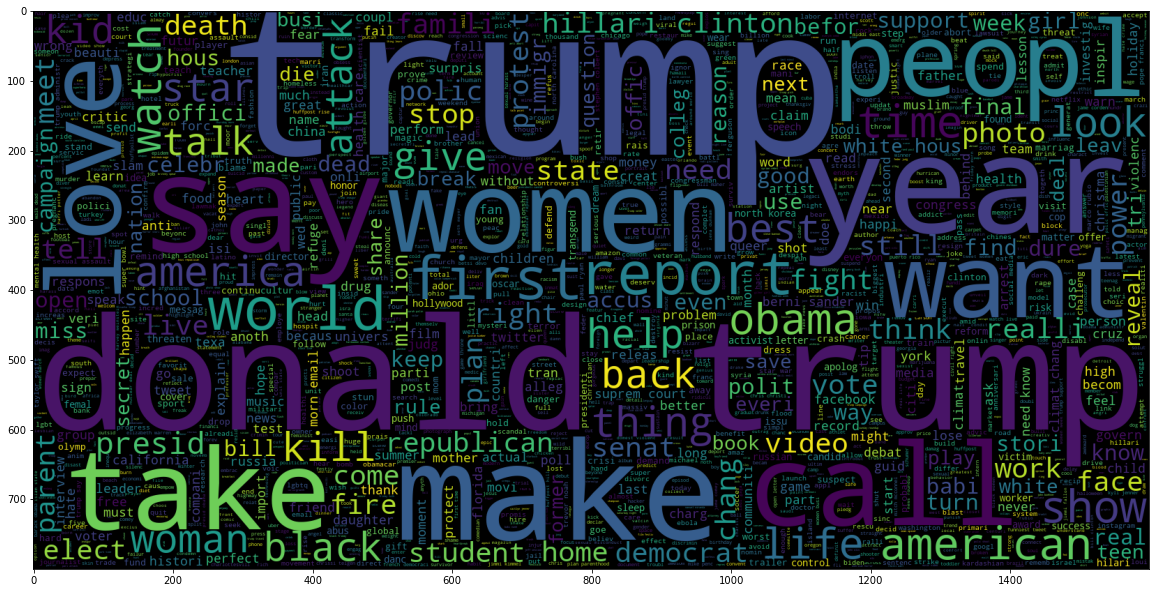

In [22]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.is_sarcastic == 0].headline))
plt.imshow(wc)

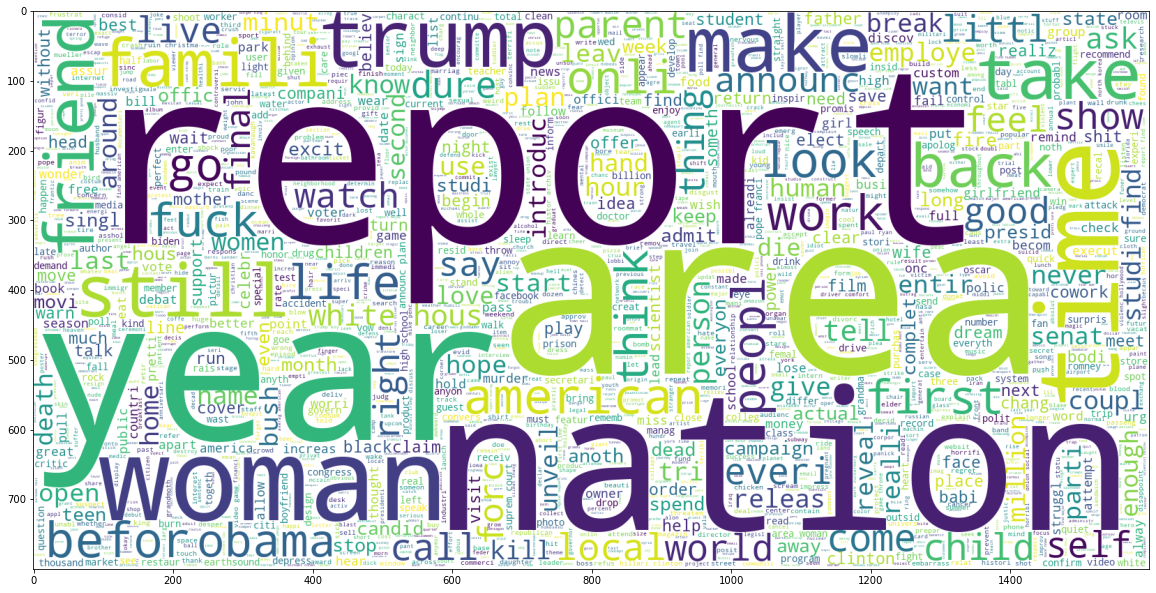

In [23]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800,background_color='white').generate(" ".join(data[data.is_sarcastic == 1].headline))
plt.imshow(wc)

Text(0.5, 0.98, 'Average word length in each text')

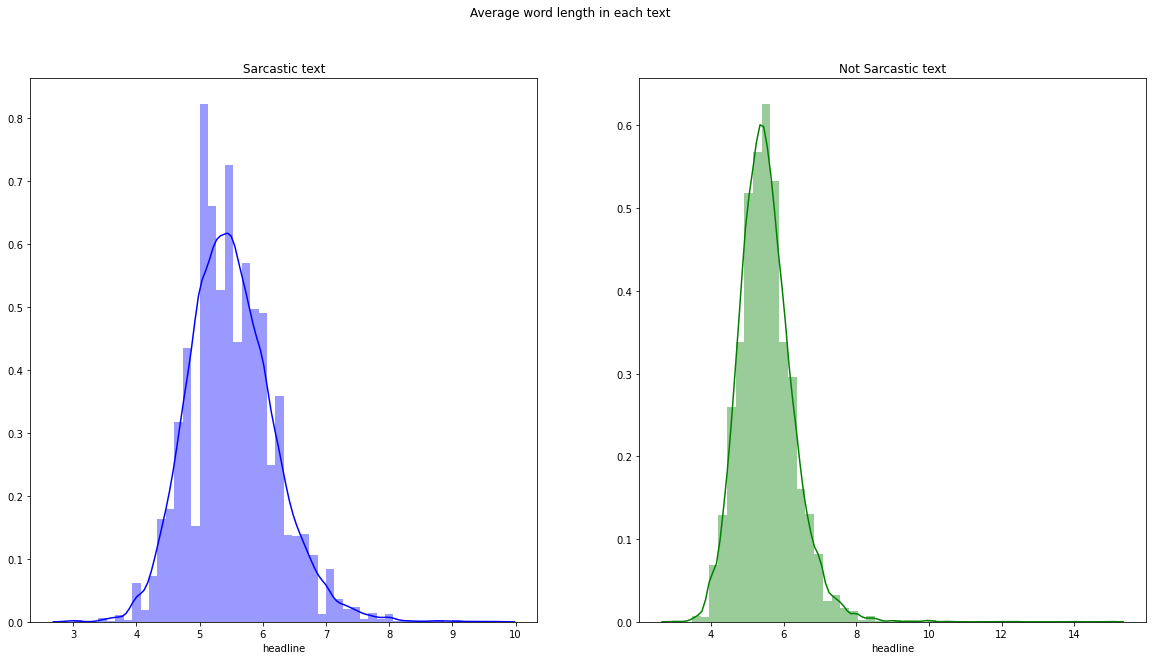

In [24]:
#Average word length in a text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word1=data[data['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(word1.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('Sarcastic text')

word2=data[data['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word2.map(lambda x: np.mean(x)),ax=ax2,color='green')

ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

In [64]:
word1

0                   [12, 9, 6, 8, 5, 4, 4]
3                       [9, 7, 7, 4, 3, 4]
4                 [6, 4, 6, 5, 3, 4, 6, 7]
7        [7, 7, 6, 4, 5, 4, 4, 4, 4, 7, 4]
8                 [6, 6, 3, 4, 4, 8, 6, 4]
                       ...                
28612                      [6, 6, 4, 4, 6]
28614                      [3, 6, 4, 8, 6]
28615                    [6, 6, 8, 10, 10]
28617             [3, 5, 7, 5, 9, 4, 5, 5]
28618                            [7, 4, 4]
Name: headline, Length: 13634, dtype: object

In [65]:
word2

1              [5, 4, 8, 4, 5, 6, 6, 5]
2                          [5, 6, 6, 5]
5                                [5, 7]
6                       [3, 4, 3, 4, 6]
9                          [3, 6, 4, 8]
                      ...              
28607             [5, 6, 4, 4, 3, 7, 6]
28608       [7, 7, 7, 4, 7, 5, 6, 6, 4]
28609    [6, 5, 3, 4, 4, 3, 4, 8, 5, 4]
28613                [7, 5, 6, 4, 4, 4]
28616             [6, 6, 6, 4, 4, 5, 6]
Name: headline, Length: 14985, dtype: object

# TFIDF VECTORIZATION

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(stop_words = stop)
X = vec.fit_transform(data['headline'])

In [26]:
X

<28619x16606 sparse matrix of type '<class 'numpy.float64'>'
	with 184929 stored elements in Compressed Sparse Row format>

In [27]:
y = data['is_sarcastic']
y = y.values
y

array([1, 0, 0, ..., 0, 1, 1])

In [28]:
pd.Series(y).value_counts()

0    14985
1    13634
dtype: int64

# SPLITTING TRAIN & TEST DATA

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y,random_state=42)

In [30]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_train, y_train)

# LOGISTIC REGRESSION

In [31]:
from sklearn.linear_model import LogisticRegression 
model1 = LogisticRegression()
model1.fit(X_res, y_res)
y_predLR = model1.predict(X_test)

In [32]:
y_predLR

array([0, 0, 0, ..., 1, 1, 1])

In [33]:
y_test

array([0, 0, 1, ..., 0, 1, 1])

In [34]:
accuracy = accuracy_score(y_test,y_predLR)*100
accuracy

78.10971348707197

In [35]:
confusion_matrix(y_test,y_predLR)

array([[2382,  615],
       [ 638, 2089]])

In [36]:
print(classification_report(y_test,y_predLR))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2997
           1       0.77      0.77      0.77      2727

    accuracy                           0.78      5724
   macro avg       0.78      0.78      0.78      5724
weighted avg       0.78      0.78      0.78      5724



# RANDOM FOREST CLASSIFIER

In [37]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier()
model2.fit(X_res, y_res)
y_predRFC = model2.predict(X_test)

In [38]:
y_predRFC

array([0, 0, 0, ..., 0, 1, 0])

In [39]:
y_test

array([0, 0, 1, ..., 0, 1, 1])

In [40]:
accuracy = accuracy_score(y_test,y_predRFC)*100
accuracy

75.80363382250175

In [41]:
confusion_matrix(y_test,y_predRFC)

array([[2491,  506],
       [ 879, 1848]])

In [42]:
print(classification_report(y_test,y_predRFC))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78      2997
           1       0.79      0.68      0.73      2727

    accuracy                           0.76      5724
   macro avg       0.76      0.75      0.75      5724
weighted avg       0.76      0.76      0.76      5724



# XGB CLASSIFIER


In [43]:
from xgboost import XGBClassifier 
model3 = XGBClassifier()
model3.fit(X_res, y_res)
y_predXGB = model3.predict(X_test)

In [44]:
y_predXGB

array([0, 0, 0, ..., 0, 1, 1])

In [45]:
y_test

array([0, 0, 1, ..., 0, 1, 1])

In [46]:
accuracy = accuracy_score(y_test,y_predXGB)*100
accuracy

70.49266247379455

In [47]:
confusion_matrix(y_test,y_predXGB)

array([[2494,  503],
       [1186, 1541]])

In [48]:
print(classification_report(y_test,y_predXGB))

              precision    recall  f1-score   support

           0       0.68      0.83      0.75      2997
           1       0.75      0.57      0.65      2727

    accuracy                           0.70      5724
   macro avg       0.72      0.70      0.70      5724
weighted avg       0.71      0.70      0.70      5724



# SUPPORT VECTOR MACHINE

In [49]:
from sklearn.svm import SVC  
model4= SVC()
model4.fit(X_res,y_res)
y_predSVM = model4.predict(X_test)

In [50]:
y_predSVM

array([0, 0, 0, ..., 1, 1, 1])

In [51]:
y_test

array([0, 0, 1, ..., 0, 1, 1])

In [52]:
accuracy = accuracy_score(y_test,y_predSVM)*100
accuracy

79.38504542278127

In [53]:
confusion_matrix(y_test,y_predSVM)

array([[2494,  503],
       [ 677, 2050]])

In [54]:
print(classification_report(y_test,y_predSVM))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      2997
           1       0.80      0.75      0.78      2727

    accuracy                           0.79      5724
   macro avg       0.79      0.79      0.79      5724
weighted avg       0.79      0.79      0.79      5724



# K-NEAREST NEIGHBOUR

In [55]:
from sklearn.neighbors import KNeighborsClassifier
model5 = KNeighborsClassifier(n_neighbors =3)
model5.fit(X_res, y_res)
y_predKNN = model5.predict(X_test)
accuracy_score(y_test,y_predKNN)*100                           
  

56.95317959468903

In [56]:
confusion_matrix(y_test,y_predKNN)

array([[2297,  700],
       [1764,  963]])

In [57]:
print(classification_report(y_test,y_predKNN))

              precision    recall  f1-score   support

           0       0.57      0.77      0.65      2997
           1       0.58      0.35      0.44      2727

    accuracy                           0.57      5724
   macro avg       0.57      0.56      0.54      5724
weighted avg       0.57      0.57      0.55      5724



# NAIVE BAYES

In [58]:
from sklearn.naive_bayes import MultinomialNB
model6 = MultinomialNB()

In [59]:
model6.fit(X_res, y_res)

MultinomialNB()

In [60]:
y_predNB=model6.predict(X_test)

In [61]:
accuracy = accuracy_score(y_test,y_predNB)*100
accuracy

78.72117400419287

In [62]:
confusion_matrix(y_test,y_predNB)

array([[2379,  618],
       [ 600, 2127]])

In [63]:
print(classification_report(y_test,y_predNB))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2997
           1       0.77      0.78      0.78      2727

    accuracy                           0.79      5724
   macro avg       0.79      0.79      0.79      5724
weighted avg       0.79      0.79      0.79      5724

